# Assignment 2 - House Prices: Advanced Regression Techniques

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn import preprocessing
from numpy import array
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline
sns.set()

## Import Data
'train_clean.csv' and 'test_clean.csv' is the cleaned up trained data set that worked on in Assignment 1.

In [2]:
# Create file path
train_clean_file = os.path.join(os.getcwd(), 'data', 'train_clean.csv')
test_clean_file = os.path.join(os.getcwd(), 'data', 'test_clean.csv')

# Load csv into pandas df
df_train_clean = pd.read_csv(train_clean_file)
df_test_clean = pd.read_csv(test_clean_file)

df_train_clean.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqft,TotalBath,HouseAge,ReModeled
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,208500,2566,3.5,5,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,5,2007,WD,Normal,181500,2524,2.5,31,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,9,2008,WD,Normal,223500,2706,3.5,7,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,2,2006,WD,Abnorml,140000,2473,2.0,91,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,12,2008,WD,Normal,250000,3343,3.5,8,0


In [122]:
df_train_clean['YearRemodAdd']

0       2003
1       1976
2       2002
3       1970
4       2000
        ... 
1453    2000
1454    1988
1455    2006
1456    1996
1457    1965
Name: YearRemodAdd, Length: 1458, dtype: int64

### Add the count of years that it took to remodel based on  'YearRemodAdd'  and 'YearBuilt' features

In [124]:
df_train_clean['RemodYears'] = df_train_clean['YearRemodAdd'] - df_train_clean['YearBuilt']
df_train_clean.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqft,TotalBath,HouseAge,ReModeled,RemodYears
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,2,2008,WD,Normal,208500,2566,3.5,5,0,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,5,2007,WD,Normal,181500,2524,2.5,31,0,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,9,2008,WD,Normal,223500,2706,3.5,7,1,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,2,2006,WD,Abnorml,140000,2473,2.0,91,1,55
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,12,2008,WD,Normal,250000,3343,3.5,8,0,0


## Check corrlation

In [125]:
corr_mat = df_train_clean.corr().SalePrice.sort_values(ascending=False)
corr_mat.head(11)

SalePrice       1.000000
TotalSqft       0.832877
OverallQual     0.795774
GrLivArea       0.734968
TotalBsmtSF     0.651153
GarageCars      0.641047
TotalBath       0.635896
1stFlrSF        0.631530
GarageArea      0.629217
FullBath        0.562165
TotRmsAbvGrd    0.537769
Name: SalePrice, dtype: float64

## 1. Conduct your analysis using a cross-validation design.

In [36]:
x = df_train_clean[['TotalSqft', 'OverallQual', 'TotalBsmtSF', 'GarageCars']]
y = df_train_clean['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1093, 4) (365, 4) (1093,) (365,)


In [37]:
# Standardizing the scales
ss = StandardScaler()
xs = ss.fit_transform(x_train)

In [42]:
lin_reg = LinearRegression()
lin_reg.fit(xs, y_train)

print('labels\n', x.columns)
print('Coefficients: \n', lin_reg.coef_)
print('Intercept: \n', lin_reg.intercept_)
print('R2 for Train:', lin_reg.score(xs, y_train ))
print('R2 for Test (cross validation)', lin_reg.score(x_test, y_test))

labels
 Index(['TotalSqft', 'OverallQual', 'TotalBsmtSF', 'GarageCars'], dtype='object')
Coefficients: 
 [40588.50492782 27793.92238832 -3291.0510298  11020.97113989]
Intercept: 
 178976.04025617565
R2 for Train: 0.8045860973811353
R2 for Test (cross validation) -1473830.5152127286


In [43]:
pd.DataFrame( list(zip(x.columns, lin_reg.coef_)),
            columns=['features', 'estimatedCoeffs'])

,features,estimatedCoeffs
0,TotalSqft,40588.504928
1,OverallQual,27793.922388
2,TotalBsmtSF,-3291.051030
3,GarageCars,11020.971140


In [44]:
score = cross_val_score(lin_reg, xs, y_train, cv=5)

print(f'CV Score: {score}')
print('R2_avg: %0.2f (+/- %0.2f)'%(score.mean(), score.std() * 2))

CV Score: [0.79097695 0.82811912 0.78729236 0.80999369 0.79189987]
R2_avg: 0.80 (+/- 0.03)


## 2. Conduct EDA and provide appropriate visualizations in the process.

## 3. Build a minimum of two separate regression models using the training set.

In [46]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
print(f"Model Score: {lin_reg.score(x_train, y_train)}")

Model Score: 0.8045860973811353


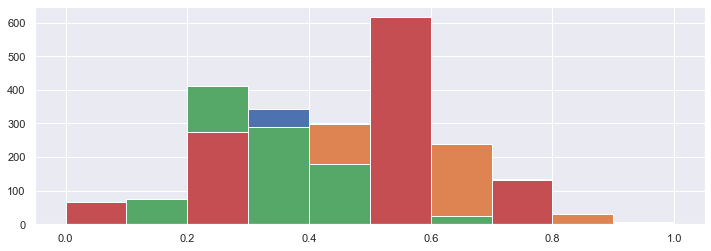

In [47]:
### MinMaxScaler
fig, ax = plt.subplots(figsize=(12, 4))

scaler = MinMaxScaler()
x_minmax_train = scaler.fit_transform(x_train)

### Scale test set
x_minmax_test = scaler.fit_transform(x_test)

ax.hist(x_minmax_train [:,0]);
ax.hist(x_minmax_train [:,1]);
ax.hist(x_minmax_train [:,2]);
ax.hist(x_minmax_train [:,3]);

### Linear Regression

In [48]:
reg = LinearRegression()
reg.fit(x_minmax_train, y_train)
print(f'Linear Regression coefficients: {reg.coef_}')
print(f'Linear Regression intercept: {reg.intercept_}')
print(f"Model Score: {reg.score(x_minmax_train, y_train)}")

# model evaluation for training set
y_train_predict = reg.predict(x_minmax_train)

# calculating the intercept and slope for the regression line
b, m = np.polynomial.polynomial.polyfit(y_train, y_train_predict, 1)

Linear Regression coefficients: [323762.01680274 179994.54752283 -25555.15106736  58732.47329721]
Linear Regression intercept: -56720.78988255447
Model Score: 0.8045860973811354


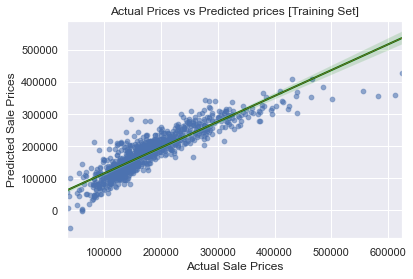

In [49]:
sns.scatterplot(x=y_train, y=y_train_predict, alpha=0.4)
sns.regplot(x=y_train, y=y_train_predict, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y_train), y=np.unique(np.poly1d(b + m * np.unique(y_train))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices")
plt.ylabel("Predicted Sale Prices")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

### Lasso regression

In [148]:
x2 = df_train_clean[['Id', 'TotalSqft', 'OverallQual', 'TotalBsmtSF', 'GarageCars', 
                    'TotalBath', '1stFlrSF', 'GarageArea', 'FullBath', 'TotRmsAbvGrd']]
y2 = df_train_clean['SalePrice']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2)

print(x_train2.shape, x_test2.shape, y_train2.shape, y_test2.shape)

(1093, 10) (365, 10) (1093,) (365,)


In [149]:
scaler = MinMaxScaler()
x_minmax_train2 = scaler.fit_transform(x_train2)

### Scale test set
x_minmax_test2 = scaler.fit_transform(x_test2)

In [150]:
lasso_reg = Lasso(normalize=True)
lasso_reg.fit(x_minmax_train2, y_train2)
print(f'Linear Regression coefficients: {lasso_reg.coef_}')
print(f'Linear Regression intercept: {lasso_reg.intercept_}')
print(f"Model Score: {lasso_reg.score(x_minmax_train2, y_train2)}")

# model evaluation for training set
y_train_predict2 = lasso_reg.predict(x_minmax_train2)

# calculating the intercept and slope for the regression line
b, m = np.polynomial.polynomial.polyfit(y_train2, y_train_predict2, 1)

Linear Regression coefficients: [ -1521.17985595 337037.02042051 174006.17464235 -62789.47346413
  11534.92816539  72566.72524651  22742.2417203   52757.19749768
 -33299.33293246 -17010.30402824]
Linear Regression intercept: -11996.05397094143
Model Score: 0.8152720748725008


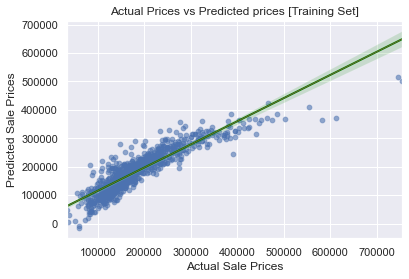

In [151]:
sns.scatterplot(x=y_train2, y=y_train_predict2, alpha=0.4)
sns.regplot(x=y_train2, y=y_train_predict2, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y_train2), y=np.unique(np.poly1d(b + m * np.unique(y_train2))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices")
plt.ylabel("Predicted Sale Prices")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

## 4. Evaluate polynomial, indicator, dichotomous, & piecewise model components

### Polynomial Regression

In [72]:
"Creates a polynomial regression model for the given degree"
poly_features = PolynomialFeatures(degree=2, include_bias=False)
   
# transform the features to higher degree features.
x_train_poly = poly_features.fit_transform(x_minmax_train)
   
# fit the transformed features to Linear Regression
poly_model = LinearRegression()

poly_model.fit(x_train_poly, y_train)

print(poly_model.intercept_)
print(lin_reg.coef_)
     
# predicting on training data-set
y_train_predicted = poly_model.predict(x_train_poly)
   
# predicting on test data-set
y_test_predicted = poly_model.predict(poly_features.fit_transform(x_test))

98134.79999092528
[322796.24337354 178811.09664899 -21190.55458514  64625.08530566]


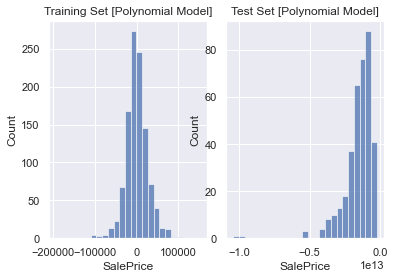

In [62]:
y_train_residual = y_train_predicted - y_train
y_test_residual = y_test_predicted - y_test


fig, axes = plt.subplots(2, 1)
# Adjust the subplot layout parameters
fig.subplots_adjust(hspace=0.125, wspace=0.125)

plt.subplot(1, 2, 1)
sns.histplot(y_train_residual, bins=25)
plt.title('Training Set [Polynomial Model]')

plt.subplot(1, 2, 2)
sns.histplot(y_test_residual, bins=25)
plt.title('Test Set [Polynomial Model]')

plt.show()

In [69]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(labels=["train","val"])

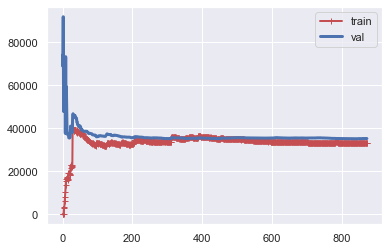

In [70]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, x_minmax_train, y_train)

### Indicator

### Dichotomous
Dichotomous is when the axis is divided into 2 branches (such as yes or no). This is seen when prefroaming a Binary Logistic Regression.

[sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [81]:
x3 = df_train_clean[['ReModeled']]
y3 = df_train_clean['SalePrice']
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3)

print(x_train3.shape, x_test3.shape, y_train3.shape, y_test3.shape)

(1093, 1) (365, 1) (1093,) (365,)


In [83]:
# Standardizing the scales
ss = StandardScaler()
xs3 = ss.fit_transform(x_train3)

clf = LogisticRegression()
clf.fit(xs3, y_train3)
print(f"Model Score: {clf.score(xs3, y_train3)}")


# model evaluation for training set
y_train_predict3 = clf.predict(xs3)

# calculating the intercept and slope for the regression line
b, m = np.polynomial.polynomial.polyfit(y_train3, y_train_predict3, 1)

Model Score: 0.01738334858188472


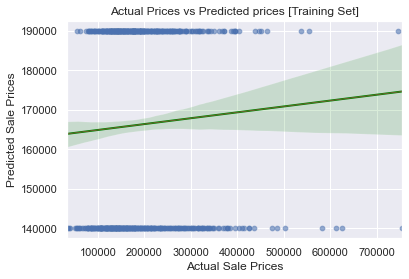

In [84]:
sns.scatterplot(x=y_train3, y=y_train_predict3, alpha=0.4)
sns.regplot(x=y_train3, y=y_train_predict3, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y_train3), y=np.unique(np.poly1d(b + m * np.unique(y_train3))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices")
plt.ylabel("Predicted Sale Prices")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

### Piecewise model

In [108]:
x4 = df_train_clean[['TotalSqft', 'OverallQual', 'TotalBsmtSF', 'GarageCars']]
y4 = df_train_clean['SalePrice']
x_train4, x_test4, y_train4, y_test4 = train_test_split(x4, y4)

print(x_train4.shape, x_test4.shape, y_train4.shape, y_test4.shape)

(1093, 4) (365, 4) (1093,) (365,)


In [109]:
model = PiecewiseRegressor(verbose=True,
                           binner=DecisionTreeRegressor(min_samples_leaf=300))
model.fit(x_train4, y_train4)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


PiecewiseRegressor(binner=DecisionTreeRegressor(min_samples_leaf=300),
                   estimator=LinearRegression(), verbose=True)

In [110]:
pred = model.predict(x_test4)
pred[:5]

array([154928.56405632, 115018.35434241, 154105.37878327, 117789.22069699,
       101467.09105834])

In [115]:
x_test4.iloc[:, 0].values

array([2184, 1799, 2150, 1470, 1382, 1864, 2884, 2596, 2632, 3197, 2742,
       4202, 2654, 2311, 1344, 1890, 2550, 3555, 2008, 1764, 2104, 2283,
       2328, 2766, 3569, 2778, 4694, 2845, 2278, 1728, 2651, 1778, 2164,
       1846, 4463, 3139, 3540, 3260, 2316, 2649, 3440, 1632, 1973, 2736,
       2480, 1568, 2648, 2058, 1920, 2226, 3322, 1562, 1880, 3882, 2010,
       2652, 2020, 2303, 1450, 1728, 2074, 2506, 2028, 3480, 3372, 1040,
       2910, 1938, 1932, 1040, 1973, 2680, 4796, 2016, 2445, 3418, 3231,
       1814, 3206, 4320, 2232, 2121, 3186, 4576, 1728, 1632, 3232, 2688,
       2416, 2494, 3356, 2684, 1743, 3708, 3994, 3004, 4354, 2370, 2770,
       2492, 2110, 2628, 2888, 2416, 2595, 2395, 2016, 3350, 1696, 2604,
       1970, 2104, 2845, 1852, 2265, 1998, 2484, 1872, 2148, 2039, 4159,
       2777, 1048, 2630, 3993, 1948, 2424, 3572, 2614, 3228, 2184, 1728,
       1700, 1850, 2453, 3418, 2034, 2104, 2988, 1396, 1664, 2542, 4263,
       2146, 2310, 1812, 2978, 4929, 4026, 2549, 30

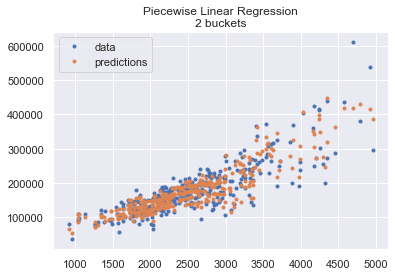

In [116]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_test4.iloc[:, 0].values, y_test4, ".", label='data')
ax.plot(x_test4.iloc[:, 0].values, pred, ".", label="predictions")
ax.set_title("Piecewise Linear Regression\n2 buckets")
ax.legend();

In [119]:
print(f"Model Score: {model.score(x_train4, y_train4)}")

Model Score: 0.8560066070192289


## 5. Create at least one feature from the data set

In [160]:
x_test_final = scaler.transform(x_test2)
preds = lasso_reg.predict(x_test_final)
preds = pd.DataFrame(preds,columns=['SalePrice'])
preds.head()

,SalePrice
0,165453.567338
1,253511.059675
2,269805.951447
3,142646.442597
4,147359.672580


In [159]:
preds['Id'] = x_test2['Id']
# preds = preds[['Id','SalePrice']]
preds

,Id,SalePrice
0,NaN,165453.567338
1,NaN,253511.059675
2,NaN,269805.951447
3,NaN,142646.442597
4,NaN,147359.672580
...,...,...
360,NaN,199780.546079
361,NaN,151067.293955
362,363.0,235601.731698
363,364.0,257699.927594


In [158]:
preds

,Id,SalePrice
0,NaN,165453.567338
1,NaN,253511.059675
2,NaN,269805.951447
3,NaN,142646.442597
4,NaN,147359.672580
...,...,...
360,NaN,199780.546079
361,NaN,151067.293955
362,363.0,235601.731698
363,364.0,257699.927594
